# Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import Subset
import time
from torchvision.datasets import MNIST
import pandas as pd
import os
import seaborn as sns   


/Users/gadmohamed/miniforge3/envs/thesis38/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [3]:




def load_mnist(batch_size=64):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])

    trainset = MNIST(root='./data', train=True, download=True, transform=transform)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = MNIST(root='./data', train=False, download=True, transform=transform)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = [str(i) for i in range(10)]  # MNIST has 10 classes (digits 0 through 9)

    return trainloader, testloader, classes

# Function to load and preprocess CIFAR-10 dataset
def load_cifar10(batch_size=64):
    transform_train = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    transform_test = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ])

    trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
    trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)

    testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
    testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

    classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    return trainloader, testloader, classes



class CNNModel(nn.Module):
    def __init__(self, input_shape, output_classes):
        super(CNNModel, self).__init__()

        # Define the convolutional layers
        self.conv1 = nn.Conv2d(in_channels=input_shape[0], out_channels=20, kernel_size=3, stride=1, padding=1)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2 = nn.Conv2d(in_channels=20, out_channels=40, kernel_size=3, stride=1, padding=1)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Calculate the input size for the fully connected layers
        conv_output_size = self._get_conv_output_size(input_shape)

        # Define the fully connected layers
        self.fc1 = nn.Linear(conv_output_size, 300)
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(300, output_classes)
        self.softmax = nn.Softmax(dim=1)

    def _get_conv_output_size(self, input_shape):
        # Calculate the output size of the convolutional layers
        x = torch.randn(1, *input_shape)
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))
        return x.view(1, -1).size(1)

    def forward(self, x):
        # Forward pass through convolutional layers
        x = self.pool1(self.relu1(self.conv1(x)))
        x = self.pool2(self.relu2(self.conv2(x)))

        # Reshape for fully connected layers
        x = x.view(x.size(0), -1)

        # Forward pass through fully connected layers
        x = self.relu3(self.fc1(x))
        x = self.fc2(x)
        x = self.softmax(x)
        return x


class ANNModel(nn.Module):
    def __init__(self, input_shape, output_classes):
        super(ANNModel, self).__init__()

        # Calculate the total input size
        input_size = input_shape[0] * input_shape[1] * input_shape[2]

        # Define the layers
        self.fc1 = nn.Linear(input_size, 256)
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(256, 128)
        self.relu2 = nn.ReLU()
        self.fc3 = nn.Linear(128, output_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        # Reshape input to (batch_size, input_size)
        x = x.view(x.size(0), -1)

        # Forward pass
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        x = self.softmax(x)
        return x






# Function to train the model
def train_model(model, trainloader, testloader, thresh, num_epochs=10):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    history = []

    # Initialize sample weights (1/n)
    n = len(trainloader.dataset)
    weights = torch.ones(n) / n
    # initialize threshold (1/2n) -- does not change
    threshold = 1 / (2 * n)
    if thresh is not None :
      threshold = thresh


    training_times = []
    for epoch in range(num_epochs):
      t1 = time.time()
      running_loss = 0.0

      # Apply the threshold to exclude samples, train on all samples in the first epoch
      if epoch > 0 :
        selected_indices = (weights >= threshold).nonzero().squeeze()
        new_dataset = Subset(trainloader.dataset, selected_indices)
        new_weights = Subset(weights, selected_indices)
        new_weights_np = np.array([new_weights[i] for i in range(len(new_weights))])

        print(f"new dataset size: {len(new_dataset)}, original dataset size: {n}")
        adjusted_trainloader = DataLoader(new_dataset, batch_size=trainloader.batch_size)
      else :
        selected_indices = (weights >= 0).nonzero().squeeze()
        adjusted_trainloader = DataLoader(trainloader.dataset, batch_size=trainloader.batch_size)
        new_weights_np = weights

      all_outputs, all_labels = [], []
      for i, data in enumerate(adjusted_trainloader, 0):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        all_outputs.append(outputs.detach().cpu().numpy())
        all_labels.append(labels.detach().cpu().numpy())

      if len(all_outputs) == 0 :
        print("No samples are left to train on")
        continue
      else :
        all_outputs, all_labels = np.concatenate(all_outputs, axis = 0), np.concatenate(all_labels, axis = 0)

      # Evaluate the model on the test set and save accuracy
      trainaccuracy, trainloss = evaluate_model(model, trainloader, loss_func = criterion)
      testaccuracy, testloss = evaluate_model(model, testloader, loss_func = criterion)
      history.append((trainaccuracy, trainloss, testaccuracy, testloss))

      print(f'Epoch {epoch + 1}: TrainAccuracy: {trainaccuracy}, TestAccuracy: {testaccuracy:.2%}')

      if epoch < num_epochs - 1:  # Skip update on the last epoch
        # Update sample weights
        print("accuracy:", (all_outputs.argmax(axis=1) == all_labels).sum()/len(all_outputs))
        print("sizes")
        print(new_weights_np.shape, all_outputs.shape, all_labels.shape)
        epsilon_t = (new_weights_np * (all_outputs.argmax(axis=1) != all_labels)).sum()
        alpha_t = 0.5 * np.log((1 - epsilon_t) / epsilon_t)
        Z_t = 2 * np.sqrt(epsilon_t * (1 - epsilon_t))

        for index, original_dataset_index in enumerate(selected_indices) :

          if all_outputs[index].argmax().item() != all_labels[index].item():
              weights[original_dataset_index] *= np.exp(alpha_t) / Z_t
          else:
              weights[original_dataset_index] *= np.exp(-alpha_t) / Z_t

        # print(f"weights size: {new_weights_tensor.size()}, weights sum:{new_weights_tensor.sum()}")
        print(f"max weights: {weights.max()}, min weights:{weights.min()}, threshold:{threshold}, distance of lowest2thresh: {weights.min() - threshold}")
      print("__________________________________________________")
      t2 = time.time()
      training_times.append(t2-t1)

    print('Finished Training')

    return history, training_times

# Function to evaluate the model
def evaluate_model(model, testloader, loss_func=None, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)

            if loss_func is not None:
                loss = loss_func(outputs, labels)
                total_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    average_loss = total_loss / len(testloader) if loss_func is not None else None


    return accuracy, average_loss










# Function to plot accuracy over epochs
def plot_accuracy(history):
    plt.plot(history)
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.show()



# Main

In [4]:
import pickle

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load mnist dataset
trainloader, testloader, classes = load_cifar10()
input_shape = trainloader.dataset[0][0].shape
num_classes = len(classes)

threshold_values = np.linspace(0, 1 / len(trainloader.dataset), 10)
print("thresholds:", threshold_values)

for thres in threshold_values :

  # # Train the model and get accuracy history
  model = CNNModel(input_shape = input_shape, output_classes = num_classes)
  model.to(device)

  history, times = train_model(model, trainloader, testloader, thresh = thres, num_epochs = 20)


  # Save the results to a file using pickle
  with open(f"cifar_evaluation_results_{thres}.pkl", 'wb') as f:
      pickle.dump({'history': history, 'times': times}, f)

# # Plot accuracy over epochs
# plot_accuracy(accuracy_history)


Files already downloaded and verified
Files already downloaded and verified
thresholds: [0.00000000e+00 2.22222222e-06 4.44444444e-06 6.66666667e-06
 8.88888889e-06 1.11111111e-05 1.33333333e-05 1.55555556e-05
 1.77777778e-05 2.00000000e-05]
Epoch 1: TrainAccuracy: 0.21788, TestAccuracy: 25.20%
accuracy: 0.17068
sizes
torch.Size([50000]) (50000, 10) (50000,)
max weights: 5.8589237596606836e-05, min weights:1.2058069842169061e-05, threshold:0.0, distance of lowest2thresh: 1.2058069842169061e-05
__________________________________________________
new dataset size: 50000, original dataset size: 50000
Epoch 2: TrainAccuracy: 0.2533, TestAccuracy: 29.70%
accuracy: 0.24494
sizes
(50000,) (50000, 10) (50000,)
max weights: 7.578171062050387e-05, min weights:9.82833171292441e-06, threshold:0.0, distance of lowest2thresh: 9.82833171292441e-06
__________________________________________________
new dataset size: 50000, original dataset size: 50000
Epoch 3: TrainAccuracy: 0.28046, TestAccuracy: 34.3

KeyboardInterrupt: 

# PLot

In [35]:
import matplotlib.pyplot as plt
import numpy as np

def plot_training_history(history, colors=('blue', 'orange', 'green', 'red')):
    # Extract individual arrays for train accuracy, train loss, test accuracy, and test loss
    train_accuracy = np.array([item[0] for item in history])
    train_loss = np.array([item[1] for item in history])
    test_accuracy = np.array([item[2] for item in history])
    test_loss = np.array([item[3] for item in history])

    # Create subplots with more space for the legend
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))

    # Plot train accuracy
    axes[0, 0].plot(train_accuracy, label='Train Accuracy', color=colors[0])
    axes[0, 0].set_title('Train Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')

    # Plot train loss
    axes[0, 1].plot(train_loss, label='Train Loss', color=colors[1])
    axes[0, 1].set_title('Train Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')

    # Plot test accuracy
    axes[1, 0].plot(test_accuracy, label='Test Accuracy', color=colors[2])
    axes[1, 0].set_title('Test Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy')

    # Plot test loss
    axes[1, 1].plot(test_loss, label='Test Loss', color=colors[3])
    axes[1, 1].set_title('Test Loss')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Loss')

    # Adjust layout for better spacing
    plt.tight_layout()

    # Move the legend box outside of the subplots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()

import matplotlib.pyplot as plt
import numpy as np

def compare_models(history_arrays, labels, filepath, colors=('blue', 'orange', 'green', 'red'), font_size=24):
    # Font size control
    title_fontsize = font_size
    label_fontsize = font_size
    legend_fontsize = font_size
    
    # Check if the number of history arrays and labels match
    if len(history_arrays) != len(labels):
        raise ValueError("Number of history arrays and labels must be the same.")
    
    # Create subplots with more space for the legend
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 10))

    for i, (history, label) in enumerate(zip(history_arrays, labels)):
        # Extract individual arrays for train accuracy, train loss, test accuracy, and test loss
        test_accuracy = np.array([item[2] for item in history])
        test_loss = np.array([item[3] for item in history])

        # Plot test accuracy
        axes[0].plot(test_accuracy, label=label, color=colors[i], lw = 5)
        axes[0].set_title('Test Accuracy', fontsize=title_fontsize)
        axes[0].set_xlabel('Epoch', fontsize=label_fontsize)
        axes[0].set_ylabel('Accuracy', fontsize=label_fontsize)
        axes[0].tick_params(axis='both', labelsize=font_size)  # Adjust font size for ticks

        # Plot test loss
        axes[1].plot(test_loss, label=label, color=colors[i], lw = 5)
        axes[1].set_title('Test Loss', fontsize=title_fontsize)
        axes[1].set_xlabel('Epoch', fontsize=label_fontsize)
        axes[1].set_ylabel('Loss', fontsize=label_fontsize)
        axes[1].tick_params(axis='both', labelsize=font_size)  # Adjust font size for ticks

    # Adjust layout for better spacing
    plt.tight_layout()

    # Move the legend box outside of the subplots
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0., fontsize=legend_fontsize)

    plt.savefig(filepath, bbox_inches='tight') 
    
    # Show the plot
    plt.show()

# Example usage:
# compare_models(history_arrays, labels, filepath, font_size=16)


def plot_training_times(training_times_arrays, model_labels, filepath, time_unit='seconds', colors=('blue', 'orange', 'green', 'red'), font_size=24):
    # Font size control
    title_fontsize = font_size
    label_fontsize = font_size
    legend_fontsize = font_size // 2  # Adjust the legend font size here

    # Check if the number of training time arrays and model labels match
    if len(training_times_arrays) != len(model_labels):
        raise ValueError("Number of training time arrays and model labels must be the same.")

    # Create a bar plot with more space for the legend
    fig, ax = plt.subplots(figsize=(15, 10))

    # Number of models
    num_models = len(training_times_arrays)

    # Number of epochs (assuming all models have the same number of epochs)
    num_epochs = len(training_times_arrays[0])

    # Bar width
    bar_width = 0.1

    # Plot bars for each model
    for i in range(num_models):
        model_label = model_labels[i]
        training_times = np.array(training_times_arrays[i])

        # Set positions for each group of bars
        bar_positions = np.arange(num_epochs) + i * bar_width

        ax.bar(bar_positions, training_times, bar_width, label=model_label, lw=5, color=colors[i])

    # Set labels and title
    ax.set_xlabel('Epoch', fontsize=label_fontsize)
    ax.set_ylabel(f'Training Time ({time_unit})', fontsize=label_fontsize)
    ax.set_title('Training Times Comparison', fontsize=title_fontsize)
    ax.tick_params(axis='both', labelsize=font_size)  # Adjust font size for ticks

    # Move the legend box outside of the subplot
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=legend_fontsize, borderaxespad=0.5)  # Adjust the borderaxespad to control space

    plt.savefig(filepath, bbox_inches='tight')

    # Show the plot
    plt.show()


def plot_training_times_alternative(training_times_arrays, model_labels, time_unit='seconds', colors=('blue', 'orange', 'green', 'red')):
    # Check if the number of training time arrays and model labels match
    if len(training_times_arrays) != len(model_labels):
        raise ValueError("Number of training time arrays and model labels must be the same.")

    # Create a DataFrame for easy manipulation
    df = pd.DataFrame(np.array(training_times_arrays).T, columns=model_labels)

    # Set the style using seaborn
    sns.set(style="whitegrid")

    # Create a line plot with shaded regions
    plt.figure(figsize=(12, 8))
    for i, model_label in enumerate(model_labels):
        sns.lineplot(data=df[model_label], label=model_label, color = colors[i])

    # # Shade the regions between the minimum and maximum training times
    # for i, model_label in enumerate(model_labels):
    #     plt.fill_between(df.index, df[model_label].min(), df[model_label].max(), alpha=0.2, label=model_label)

    # Set labels and title
    plt.xlabel('Epoch')
    plt.ylabel(f'Training Time ({time_unit})')
    plt.title('Training Times Comparison')

    # Place the legend outside of the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    # Show the plot
    plt.show()


cifar_evaluation_results_6.6666666666666675e-06.pkl
cifar_evaluation_results_1.1111111111111112e-05.pkl
cifar_evaluation_results_8.88888888888889e-06.pkl
cifar_evaluation_results_2e-05.pkl
cifar_evaluation_results_4.444444444444445e-06.pkl
cifar_evaluation_results_2.2222222222222225e-06.pkl
cifar_evaluation_results_1.777777777777778e-05.pkl
cifar_evaluation_results_1.555555555555556e-05.pkl
cifar_evaluation_results_1.3333333333333335e-05.pkl
cifar_evaluation_results_0.0.pkl
number of files found: 10


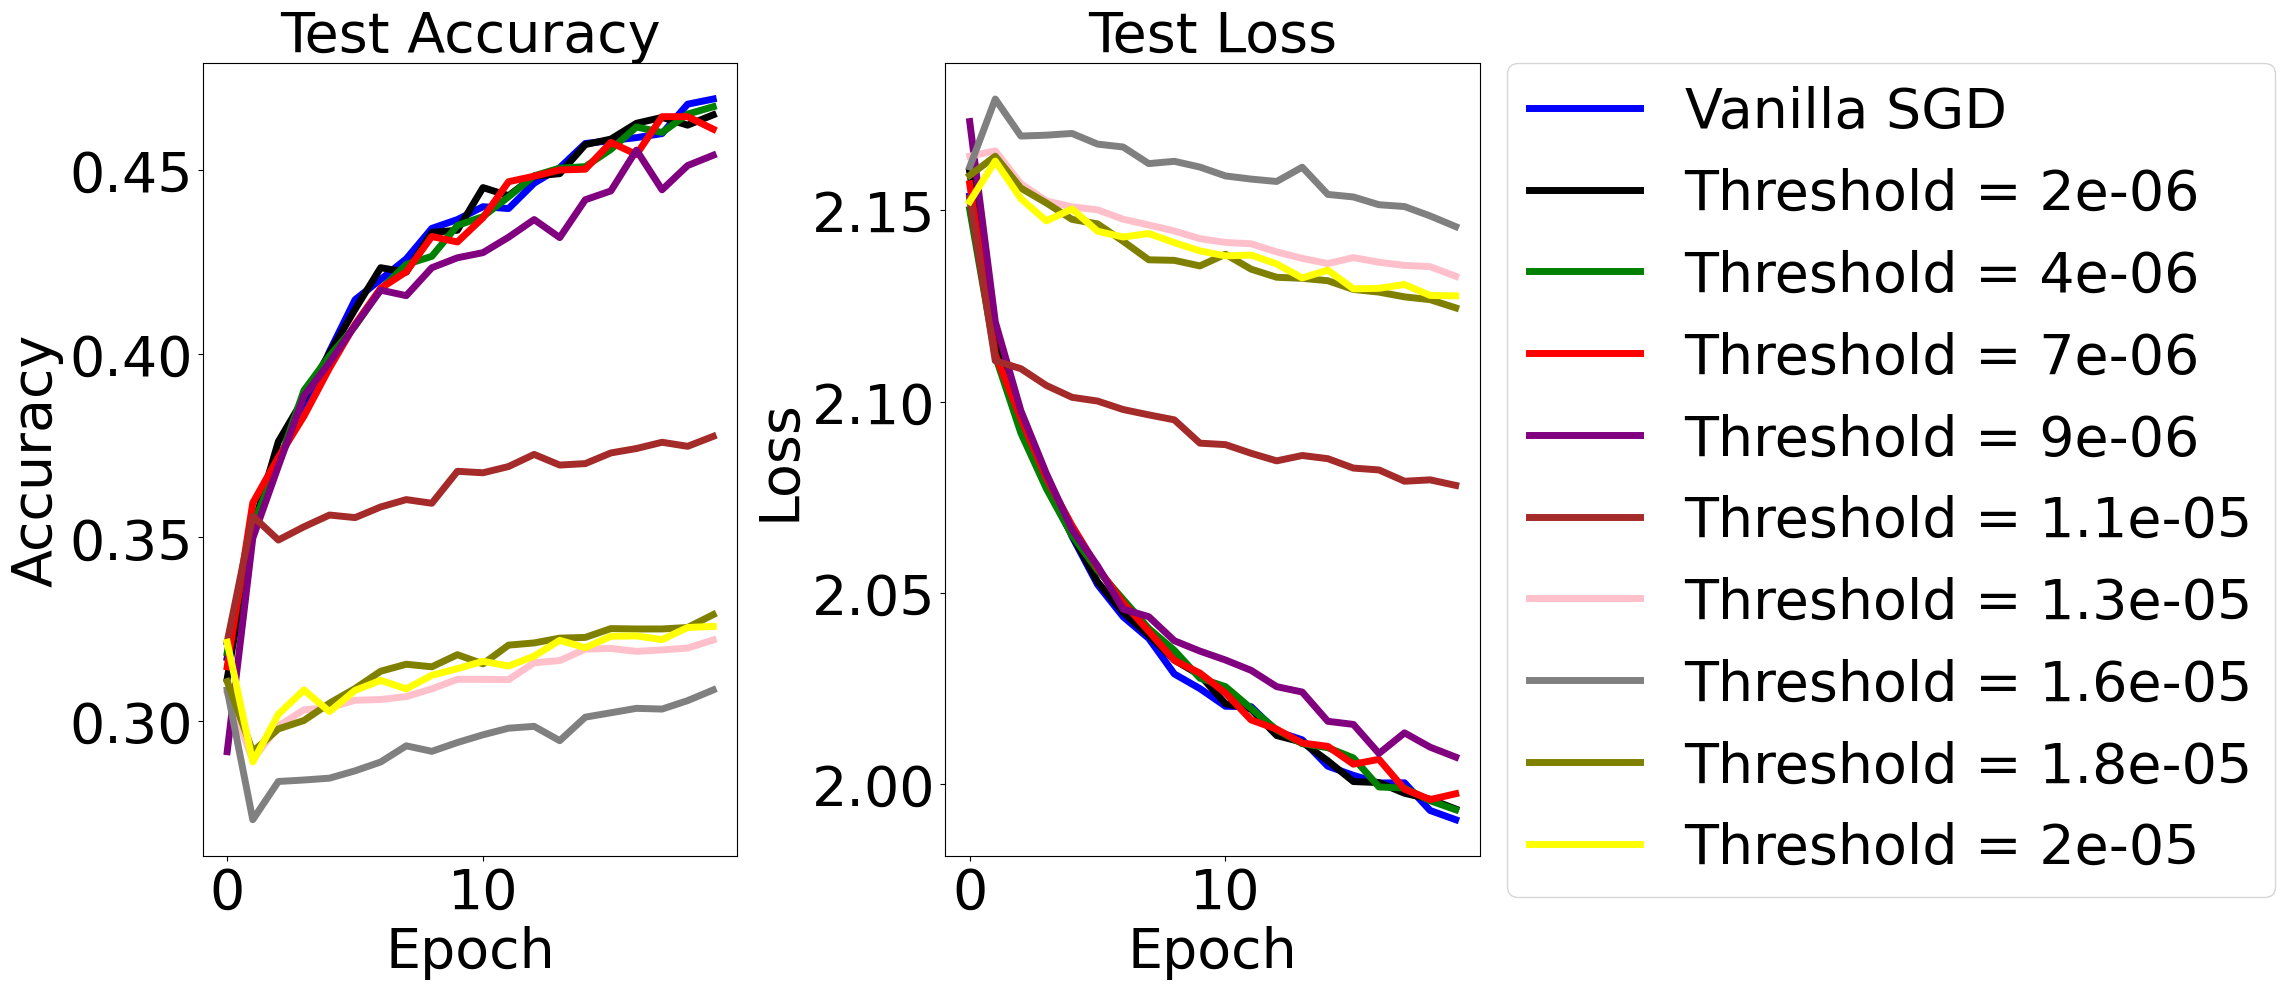

In [37]:
import os
import pickle

histories, times, labels = [], [], []

for file in os.listdir() : 
         
    if file.startswith('cifar') and file.endswith('.pkl') :
        print(file) 
        with open(file, 'rb') as f:
            results = pickle.load(f)
            histories.append(results['history'])
            times.append(results['times'])
            threshold = float(file.split('_')[-1][:-4])
            labels.append(threshold)

print(f"number of files found: {len(histories)}")
# Convert labels to array for sorting
labels = np.array(labels)

# Sort indices based on labels
sort_indices = np.argsort(labels)

# Apply sorting to arrays
histories = [histories[i] for i in sort_indices]
times = [times[i] for i in sort_indices]
labels = list(labels[sort_indices])


for i in range(len(labels) ) : 
    if labels[i] == 0.0 :
        labels[i] = 'Vanilla SGD'
    else :
        # Adaboost-like resampling
        labels[i] = f'Threshold = {round(float(labels[i]), 6)}'


colors = ('blue', 'black', 'green', 'red', 'purple', 'brown', 'pink', 'gray', 'olive', 'yellow', 'magenta') 
colors *= len(labels) // len(colors) + 1
colors = colors[:len(labels)]

filepath = "cifar_comparison.pdf"   
compare_models(history_arrays = histories, labels = labels, filepath = filepath, colors = colors, font_size = 40)

accuracy_threshold = 0.4

successful_exps_indicies = np.array(np.array([history[-1][2] for history in histories]) > accuracy_threshold)



mask = np.ones(len(histories), dtype=bool)
mask[2] = False

selected_history_arrays = np.array(histories)[mask]
selected_labels = np.array(labels)[mask]
selected_colors = np.array(colors)[mask]
selected_times = np.array(times)[mask]


# compare_models(history_arrays = selected_history_arrays, labels = selected_labels, colors = selected_colors)

In [39]:
[history[-1][2] for history in histories]

[0.4693, 0.465, 0.4672, 0.4611, 0.454, 0.3775, 0.3221, 0.3085, 0.329, 0.3258]

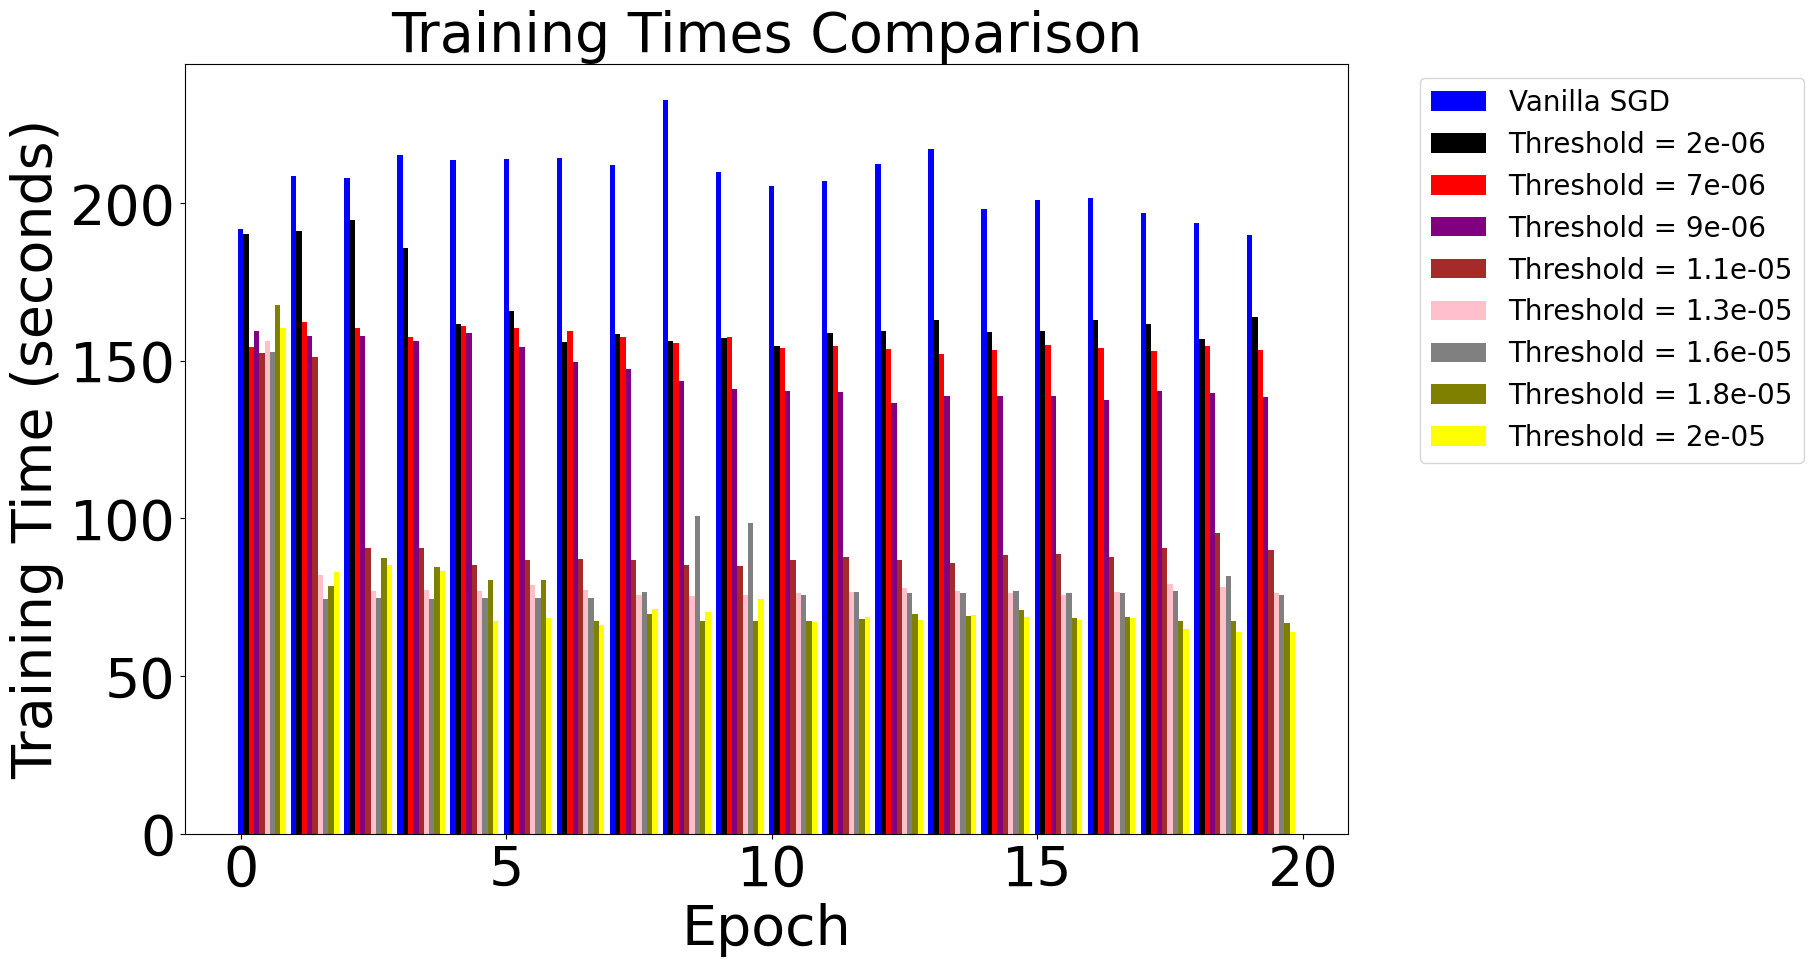

In [38]:

# times = [np.maximum(times, 300) for time in times]
filepath = "cifar_training_times.pdf"
font_size = 40
plot_training_times(training_times_arrays = selected_times, model_labels = selected_labels, filepath = filepath, colors = selected_colors, font_size = font_size)